In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = 'H:/Alzheimers-ADNI/train'
TEST_DIR = 'H:/Alzheimers-ADNI/test'

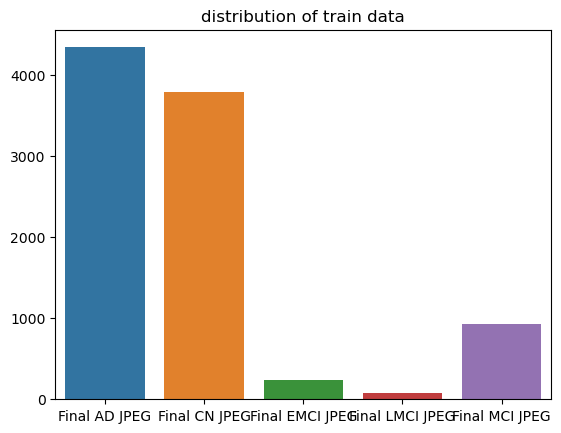

9350


In [3]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)


In [4]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

In [5]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 12961 images belonging to 5 classes.
Found 3239 images belonging to 5 classes.
Found 2575 images belonging to 5 classes.


In [6]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

58889256/58889256 [==============================] - 99s 2us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                             

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input, output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [9]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [10]:
h = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 87s 3s/step - loss: 1.7026 - accuracy: 0.4977 - val_loss: 2.8466 - val_accuracy: 0.3646
Epoch 2/10
27/27 [==============================] - 101s 4s/step - loss: 0.8797 - accuracy: 0.5475 - val_loss: 2.3165 - val_accuracy: 0.2396
Epoch 3/10
27/27 [==============================] - 112s 4s/step - loss: 0.7936 - accuracy: 0.5741 - val_loss: 3.4922 - val_accuracy: 0.2656
Epoch 4/10
27/27 [==============================] - 112s 4s/step - loss: 0.7144 - accuracy: 0.5750 - val_loss: 3.5620 - val_accuracy: 0.3333
Epoch 5/10
27/27 [==============================] - 116s 4s/step - loss: 0.7116 - accuracy: 0.6065 - val_loss: 4.1972 - val_accuracy: 0.2812
Epoch 6/10
27/27 [==============================] - 115s 4s/step - loss: 0.7138 - accuracy: 0.5926 - val_loss: 4.0140 - val_accuracy: 0.2604
Epoch 7/10
27/27 [==============================] - 115s 4s/step - loss: 0.6868 - accuracy: 0.6146 - val_loss: 3.2803 - val_accuracy: 0.2240
Epoch 8/10
27/